Download example vectors from https://github.com/erikbern/ann-benchmarks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import mkl

os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
os.environ["OPENBLAS_NUM_THREADS"] = "20"

mkl.set_num_threads(20)
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

14

In [3]:
import h5py
import numpy as np
data = h5py.File('nytimes-256-angular.hdf5', 'r')

In [4]:
def normalize(x):
    return x / (np.linalg.norm(x, axis=1).reshape(-1, 1) + 1e-5)

train_embeddings = data['train'][:]
test_embeddings = data['test'][:]
exact_indices = data['neighbors'][:, 0]

train_embeddings = normalize(train_embeddings)
test_embeddings = normalize(test_embeddings)

In [5]:
d = test_embeddings.shape[1]
d, train_embeddings.shape, test_embeddings.shape

(256, (290000, 256), (10000, 256))

# Build index

In [6]:
from fast_ivf import FastIVF
nlist = 1024
index = FastIVF(d, nlist=nlist, kmeans_batch_size=1024)
index.train(train_embeddings)

Convergence delta = 0.00026: 100%|██████████| 1000/1000 [00:06<00:00, 150.35it/s]
Assigning: 284it [00:00, 477.98it/s]                         


(array([ 2.,  7., 23., 58., 60., 76., 80., 74., 62., 44., 43., 36., 34.,
        27., 30., 18., 17., 30., 17., 14., 11., 19., 15., 10., 20.,  9.,
        18.,  5., 12.,  3.,  6.,  7.,  8.,  3.,  9.,  6.,  6.,  5.,  5.,
         9.,  9.,  5.,  5.,  0.,  3.,  2.,  3.,  3.,  5.,  0.,  0.,  5.,
         1.,  5.,  0.,  2.,  3.,  2.,  4.,  2.,  0.,  1.,  1.,  1.,  2.,
         1.,  0.,  1.,  0.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,
         2.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  27.  ,   42.56,   58.12,   73.68,   89.24,  104.8 ,  120.36,
         135.92,  151.48,  167.04,  182.6 ,  198.16,  213.72,  229.28,
         244.84,  260.4 ,  275.96,  291.52,  307.08,  322.64,  338.2 ,
         353.76,  369.32,  384.88,  400.44,  416.  ,  431.56,  447.12,
         462.68,  478.24,  493.8 ,  509.36,  524.92,  540.48,  556.04,
         571.6 ,  587.16,  602.72,  618.28,  633.84,  649.4 ,  664.96,
        

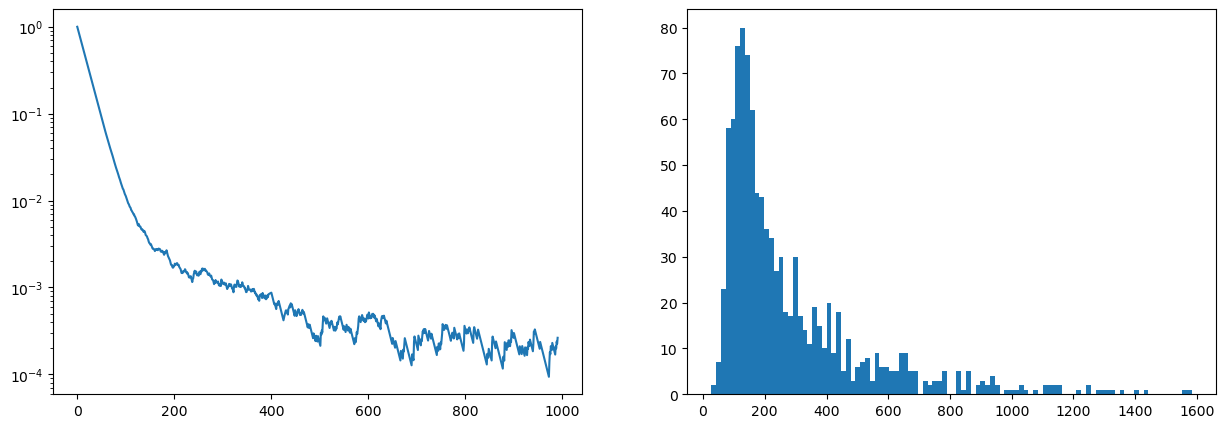

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(index.kmeans._history)
plt.yscale("log")
plt.subplot(1, 2, 2)
indices, counts = np.unique(index.kmeans._labels, return_counts=True)
plt.hist(counts, 100)

# Evaluate index

In [8]:
index.search(test_embeddings[:10], k=100)

([array([0.6693827 , 0.54850256, 0.497688  , 0.4707151 , 0.36290988,
         0.34422183, 0.32961905, 0.29399773, 0.26720798, 0.25218177,
         0.24656053, 0.23540783, 0.23384926, 0.23263758, 0.22730145,
         0.22619018, 0.22606112, 0.22586042, 0.22456561, 0.22108975,
         0.22073689, 0.21730152, 0.21688402, 0.21620506, 0.2149026 ,
         0.21489382, 0.21255238, 0.21252076, 0.2124452 , 0.21226737,
         0.21062493, 0.2091856 , 0.2090797 , 0.2086089 , 0.20794678,
         0.20784569, 0.20702514, 0.20557725, 0.2053825 , 0.20485736,
         0.20429595, 0.20399788, 0.2037768 , 0.20252824, 0.20203084,
         0.20168926, 0.20159766, 0.2005418 , 0.20038064, 0.19716436,
         0.1970205 , 0.19668944, 0.19597045, 0.19560795, 0.19516541,
         0.19486734, 0.1942783 , 0.19398338, 0.19346893, 0.19326733,
         0.19200778, 0.19174442, 0.19133137, 0.19086596, 0.19065258,
         0.19050066, 0.19047932, 0.18985215, 0.18935513, 0.18935513,
         0.1890994 , 0.18793723, 0

In [9]:
index.nprobe = 10
index.ratio_threshold = 0.5
distances, indices = index.search(test_embeddings, k=100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8268

In [10]:
%timeit index.search(test_embeddings, k=100)

482 ms ± 46.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare with Faiss IVF Index

In [11]:
import faiss

d = train_embeddings.shape[1]
nlist = 1024

quantizer = faiss.IndexFlatIP(d)
faiss_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [12]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8394

In [13]:
%timeit faiss_index.search(test_embeddings, 100)

825 ms ± 78.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare with raft IVF Index

In [14]:
import cupy as cp
from pylibraft.neighbors import ivf_flat
flatindex_params = ivf_flat.IndexParams(n_lists=nlist)
pylibraft_flatindex = ivf_flat.build(flatindex_params, cp.array(train_embeddings))

In [15]:
# Search using the built index
flatsearch_params = ivf_flat.SearchParams(n_probes=10)
distances, neighbors = ivf_flat.search(flatsearch_params, pylibraft_flatindex, cp.array(test_embeddings), 100)

accuracies = []
for i, qi in enumerate(cp.asarray(neighbors)):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7876

In [16]:
%timeit ivf_flat.search(flatsearch_params, pylibraft_flatindex, cp.array(test_embeddings), 100)

113 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Compressed IVF index

In [17]:
from fast_ivf import CompressedFastIVF

index = CompressedFastIVF(d, nlist=1024, compression_ndim=128, compressor_steps_per_epoch=1000)
index.train(train_embeddings)

2024-05-04 22:53:35.498389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 22:53:35.524605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 22:53:35.524637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 22:53:35.525254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 22:53:35.529445: I tensorflow/core/platform/cpu_feature_guar

Training compressor steps_per_epoch=1000 epoch=10 compression_ndim=128
Epoch 1/10
1000/1000 [==============================] - 5s 4ms/step - loss: 3.6597 - categorical_accuracy: 0.3760 - top_k_categorical_accuracy: 0.6040
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0929 - categorical_accuracy: 0.5782 - top_k_categorical_accuracy: 0.8201
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 1.7834 - categorical_accuracy: 0.6239 - top_k_categorical_accuracy: 0.8621
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6722 - categorical_accuracy: 0.6427 - top_k_categorical_accuracy: 0.8786
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6119 - categorical_accuracy: 0.6553 - top_k_categorical_accuracy: 0.8859
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5620 - categorical_accuracy: 0.6623 - top_k_categorical_accuracy: 0.8949
Epoch 7/10
1000/1000 [=

Adding compressed vectors: 284it [00:00, 567.97it/s]


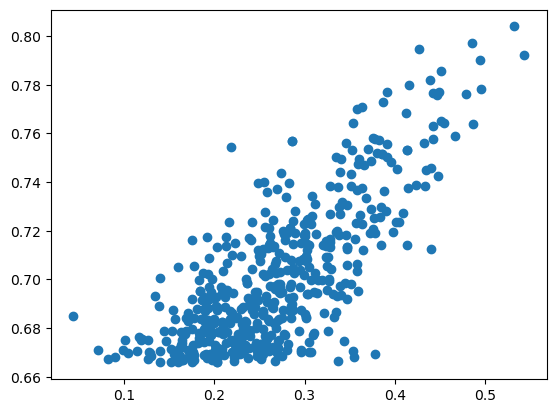

In [18]:
index.nprobe = 400
distances, indices = index.search(test_embeddings[:100], k=500, rescore=False)

idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query

plt.scatter(exact_distances, distances[idx])

In [19]:
index.nprobe = 10
index.ratio_threshold = 0.5
index.rescore_num_samples = -1
distances, indices = index.search(test_embeddings, k=100, rescore=False)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7749

In [20]:
%timeit index.search(test_embeddings, k=100, rescore=False)

257 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/hollowman/miniforge3/lib/python3.10/site-packages/fast_ivf/core.py:41: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  indices = query_indices[i]


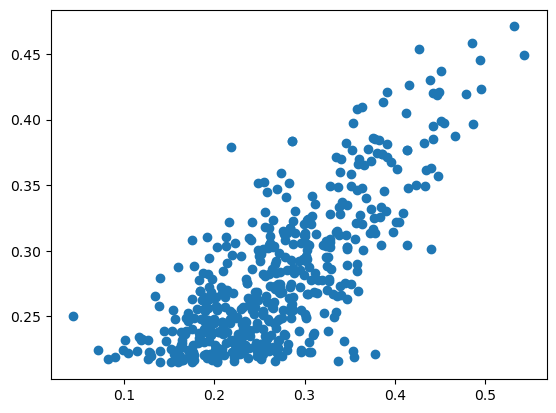

In [21]:
index.rescore_num_samples = 50
distances, indices = index.search(test_embeddings[:100], k=500, rescore=True)
idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query
plt.scatter(exact_distances, distances[idx])

# FastIVFPQ

In [22]:
from fast_ivf import FastIVFPQ

index = FastIVFPQ(d, nlist=1024, pq_num_subvectors=32, pq_num_centroids=64)
index.train(train_embeddings)

Convergence delta = 0.00005:  98%|█████████▊| 982/1000 [00:06<00:00, 155.62it/s]
Assigning: 284it [00:00, 506.51it/s]                         
Convergence delta = 0.00124: 100%|██████████| 1000/1000 [00:03<00:00, 256.73it/s]
Assigning: 2266it [00:01, 1458.06it/s]                          


In [23]:
index.nprobe = 10
index.ratio_threshold = 0.5
index.rescore_num_samples = -1
distances, indices = index.search(test_embeddings, k=100, rescore=False)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7632

In [24]:
%timeit index.search(test_embeddings, k=100, rescore=False)

452 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
nlist = 1024
m = 32
n_bits = 6 # 2 ** 6 = 64 centroids per subvector

faiss_index = faiss.IndexIVFPQ(faiss.IndexFlatIP(d), d, nlist, m, n_bits)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [26]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7247

In [27]:
%timeit faiss_index.search(test_embeddings, 100)

1.31 s ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
from pylibraft.neighbors import ivf_pq
index_params = ivf_pq.IndexParams(n_lists=nlist, pq_dim=d, pq_bits=n_bits, kmeans_n_iters=m)
pylibraft_index = ivf_pq.build(index_params, cp.array(train_embeddings))

In [29]:
# Search using the built index
search_params = ivf_pq.SearchParams(n_probes=10)
distances, neighbors = ivf_pq.search(search_params, pylibraft_index, cp.array(test_embeddings), 100)

accuracies = []
for i, qi in enumerate(cp.asarray(neighbors)):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.792

In [30]:
%timeit ivf_pq.search(search_params, pylibraft_index, cp.array(test_embeddings), 100)

78.8 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
